In [1]:
import pandas as pd
import numpy as np

from datetime import datetime, time, date, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_hierro = pd.read_csv('data/df_hierro_clean.csv', parse_dates=['datetime'])
df_hierro = df_hierro.set_index('datetime')
df_hierro.head()

,demand,diesel,wind,pump_hydro,dsch_hydro
datetime,,,,,
2016-01-01 00:00:00,5.1,5.2,0.0,0.0,0.0
2016-01-01 00:10:00,5.1,5.2,0.0,0.0,0.0
2016-01-01 00:20:00,5.3,5.4,0.0,0.0,0.0
2016-01-01 00:30:00,5.3,5.4,0.0,0.0,0.0
2016-01-01 00:40:00,5.3,5.4,0.0,0.0,0.0


In [3]:
s_imbalance = df_hierro.demand - df_hierro.wind
shortcoming = s_imbalance[s_imbalance>0].sum()/6000
demand = df_hierro.demand.sum()/6000

print(1-shortcoming/demand)

0.5634445118723967


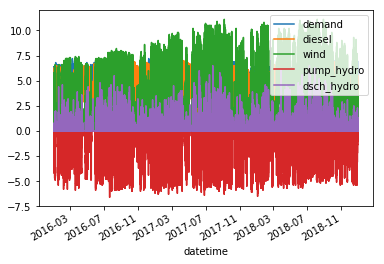

In [4]:
df_hierro.plot()

Text(0.5,1,'Zero Pumped Hydro: Wind v Diesel')

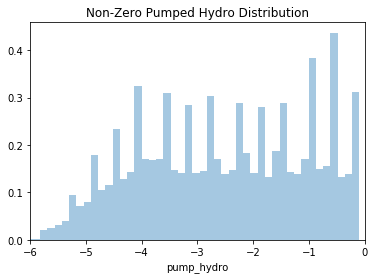

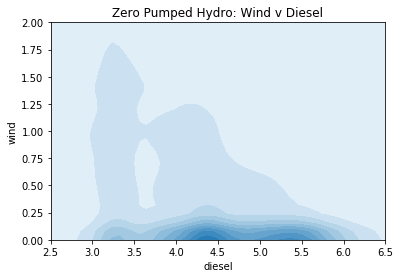

In [5]:
plt.figure()
sns.distplot(df_hierro[df_hierro.pump_hydro<0].pump_hydro, kde_kws={'alpha':0})
plt.xlim(-6, 0)
plt.title('Non-Zero Pumped Hydro Distribution')

plt.figure()
sns.kdeplot(df_hierro[df_hierro.pump_hydro==0].diesel, df_hierro[df_hierro.pump_hydro==0].wind, shade=True)
plt.xlim(2.5, 6.5)
plt.ylim(0, 2)
plt.title('Zero Pumped Hydro: Wind v Diesel')

Text(0.5,1,'Zero Discharged Hydro: Wind v Diesel')

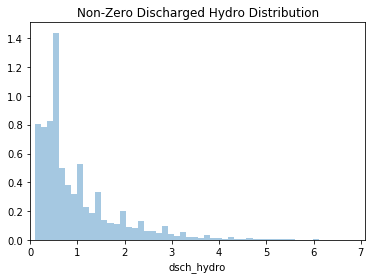

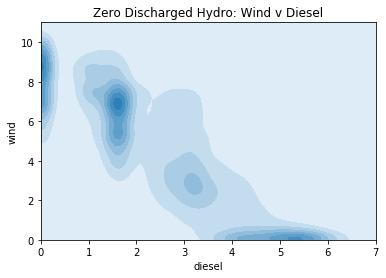

In [6]:
plt.figure()
sns.distplot(df_hierro[df_hierro.dsch_hydro>0].dsch_hydro, kde_kws={'alpha':0})
plt.xlim(0)
plt.title('Non-Zero Discharged Hydro Distribution')

plt.figure()
sns.kdeplot(df_hierro[df_hierro.dsch_hydro==0].diesel, df_hierro[df_hierro.dsch_hydro==0].wind, shade=True)
plt.xlim(0, 7)
plt.ylim(0, 11)
plt.title('Zero Discharged Hydro: Wind v Diesel')

<br>

### Identifying Reservoir Limitations

The first step is to identify long periods of time without hydro discharge

In [7]:
df_nonz_dsch_hydro = df_hierro[df_hierro.dsch_hydro!=0][['dsch_hydro']]
df_nonz_dsch_hydro['datetime'] = df_nonz_dsch_hydro.index
df_nonz_dsch_hydro['timedelta'] = df_nonz_dsch_hydro['datetime'] - df_nonz_dsch_hydro['datetime'].shift(1)
df_nonz_dsch_hydro['timedelta_mins'] = df_nonz_dsch_hydro.timedelta.dt.total_seconds()/60
df_nonz_dsch_hydro = df_nonz_dsch_hydro.drop(columns=['datetime', 'timedelta'])

df_nonz_dsch_hydro.head()

,dsch_hydro,timedelta_mins
datetime,,
2016-01-01 13:20:00,0.5,NaN
2016-01-01 13:30:00,0.6,10.0
2016-01-01 13:40:00,0.6,10.0
2016-01-01 13:50:00,0.6,10.0
2016-01-01 14:00:00,0.4,10.0


(0, 0.05)

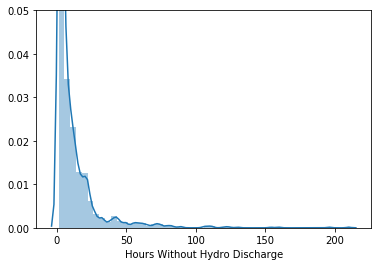

In [8]:
sns.distplot(df_nonz_dsch_hydro[df_nonz_dsch_hydro.timedelta_mins>60].timedelta_mins.dropna()/60)
plt.xlabel('Hours Without Hydro Discharge')
plt.ylim(0, 0.05)

In [9]:
s_timedelta_mins = df_nonz_dsch_hydro[df_nonz_dsch_hydro.timedelta_mins>(48*60)].timedelta_mins
print(f'Total number of events where there was no hydro discharge for more than 48h: {s_timedelta_mins.shape[0]}')
s_timedelta_mins.head()

Total number of events where there was no hydro discharge for more than 48h: 71


datetime
2016-01-16 07:50:00    4930.0
2016-02-14 13:30:00    6630.0
2016-02-17 19:50:00    3040.0
2016-02-28 07:40:00    3480.0
2016-03-11 11:40:00    4410.0
Name: timedelta_mins, dtype: float64

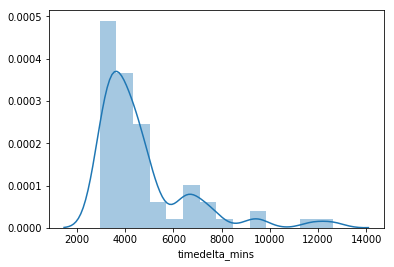

In [10]:
sns.distplot(s_timedelta_mins)

In [11]:
df_non_hydro_dsch = pd.DataFrame()
event_ends = []
event_starts = []
length = []

for event_end in s_timedelta_mins.index:
    try:
        minutes = s_timedelta_mins[s_timedelta_mins.duplicated()][event_end] - 10
        event_start = event_end - timedelta(minutes=minutes)
        df_non_hydro_dsch = df_non_hydro_dsch.append(df_hierro[str(event_start):str(event_end)].copy())
        
        event_starts += [event_start]
        event_ends += [event_end]
        length += [int(minutes)]
    except:
        pass

df_events = pd.DataFrame({'start':event_starts, 'end':event_ends, 'minutes':length})
df_events.head()

,start,end,minutes
0,2016-06-28 16:20:00,2016-07-03 06:40:00,6620
1,2016-09-08 12:10:00,2016-09-10 13:10:00,2940
2,2016-09-08 12:10:00,2016-09-10 13:10:00,2940
3,2017-05-15 17:00:00,2017-05-20 04:10:00,6430
4,2017-06-19 08:40:00,2017-06-21 17:00:00,3380


In [12]:
print(df_non_hydro_dsch.shape)
df_non_hydro_dsch.head()

(8645, 5)


,demand,diesel,wind,pump_hydro,dsch_hydro
datetime,,,,,
2016-06-28 16:20:00,5.6,2.6,3.3,-0.1,0.0
2016-06-28 16:30:00,5.6,2.6,3.8,-0.7,0.0
2016-06-28 16:40:00,5.6,2.6,3.8,-0.8,0.0
2016-06-28 16:50:00,5.6,2.5,4.5,-1.3,0.0
2016-06-28 17:00:00,5.7,2.6,5.1,-1.8,0.0


Text(0.5,1,'Zero Pumped Hydro: Wind v Diesel')

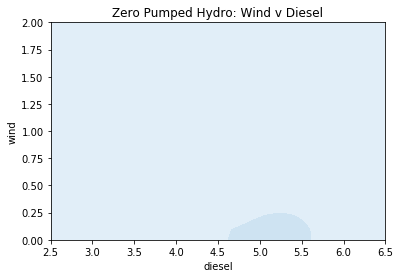

In [13]:
plt.figure()
sns.kdeplot(df_non_hydro_dsch.diesel, df_non_hydro_dsch.wind, shade=True)
plt.xlim(2.5, 6.5)
plt.ylim(0, 2)
plt.title('Zero Pumped Hydro: Wind v Diesel')

In [14]:
df_events.head()

,start,end,minutes
0,2016-06-28 16:20:00,2016-07-03 06:40:00,6620
1,2016-09-08 12:10:00,2016-09-10 13:10:00,2940
2,2016-09-08 12:10:00,2016-09-10 13:10:00,2940
3,2017-05-15 17:00:00,2017-05-20 04:10:00,6430
4,2017-06-19 08:40:00,2017-06-21 17:00:00,3380


In [15]:
df_events['diesel_pct'] = np.nan

for i in range(df_events.shape[0]):
    try:
        start = df_events.loc[i, 'start']
        end = df_events.loc[i, 'end']

        mean_pct_demand_from_diesel = (df_hierro[start:end].diesel/df_hierro[start:end].demand).mean()
        df_events.loc[i, 'diesel_pct'] = mean_pct_demand_from_diesel
    except:
        pass
    
df_events.head()

,start,end,minutes,diesel_pct
0,2016-06-28 16:20:00,2016-07-03 06:40:00,6620,0.418110
1,2016-09-08 12:10:00,2016-09-10 13:10:00,2940,NaN
2,2016-09-08 12:10:00,2016-09-10 13:10:00,2940,NaN
3,2017-05-15 17:00:00,2017-05-20 04:10:00,6430,0.187156
4,2017-06-19 08:40:00,2017-06-21 17:00:00,3380,0.924298


(0, 1)

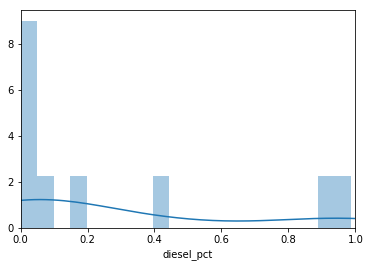

In [16]:
sns.distplot(df_events.diesel_pct.dropna(), bins=20)
plt.xlim(0, 1)

In [17]:
s_timedelta_mins.sort_values(ascending=False).head()

datetime
2016-05-31 08:10:00    12610.0
2016-04-23 18:40:00    11760.0
2017-05-14 09:50:00     9590.0
2018-10-14 10:10:00     9250.0
2017-04-19 01:40:00     7810.0
Name: timedelta_mins, dtype: float64

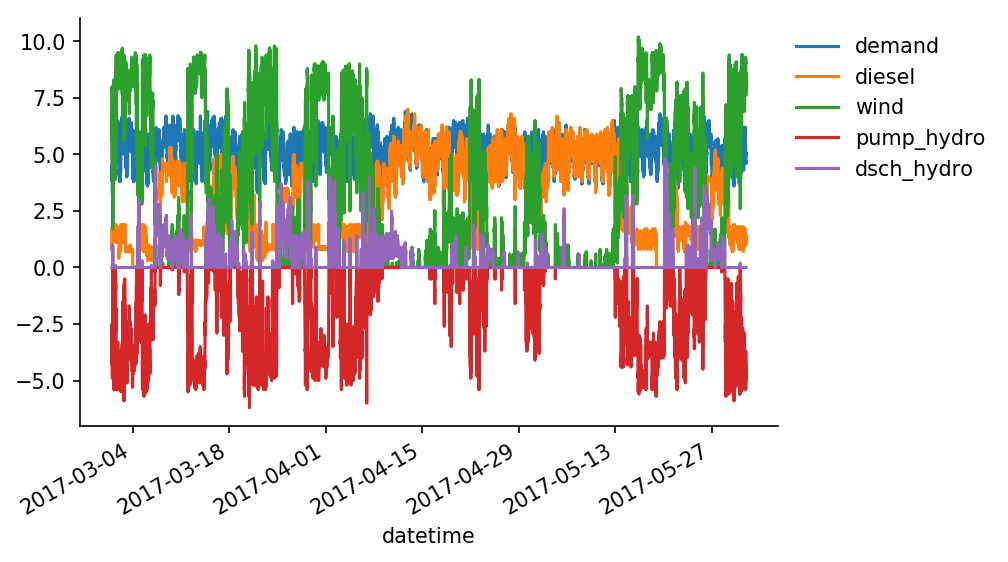

In [18]:
## Do stacked chart, have negative at bottom followed by absolute of negative to negate it.

fig = plt.figure(dpi=150)
ax = plt.subplot()

df_hierro['2017-03':'2017-05'][['demand', 'diesel', 'wind', 'pump_hydro', 'dsch_hydro']].plot(ax=ax)

plt.legend(bbox_to_anchor=(1, 1), frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

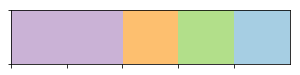

In [4]:
stacked_cmap = [(0.792156862745098, 0.6980392156862745, 0.8392156862745098), (0.792156862745098, 0.6980392156862745, 0.8392156862745098), (0.9921568627450981, 0.7490196078431373, 0.43529411764705883), (0.6980392156862745, 0.8745098039215686, 0.5411764705882353), (0.6509803921568628, 0.807843137254902, 0.8901960784313725)]
sns.palplot(stacked_cmap)

In [5]:
list(sns.color_palette("Paired"))

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

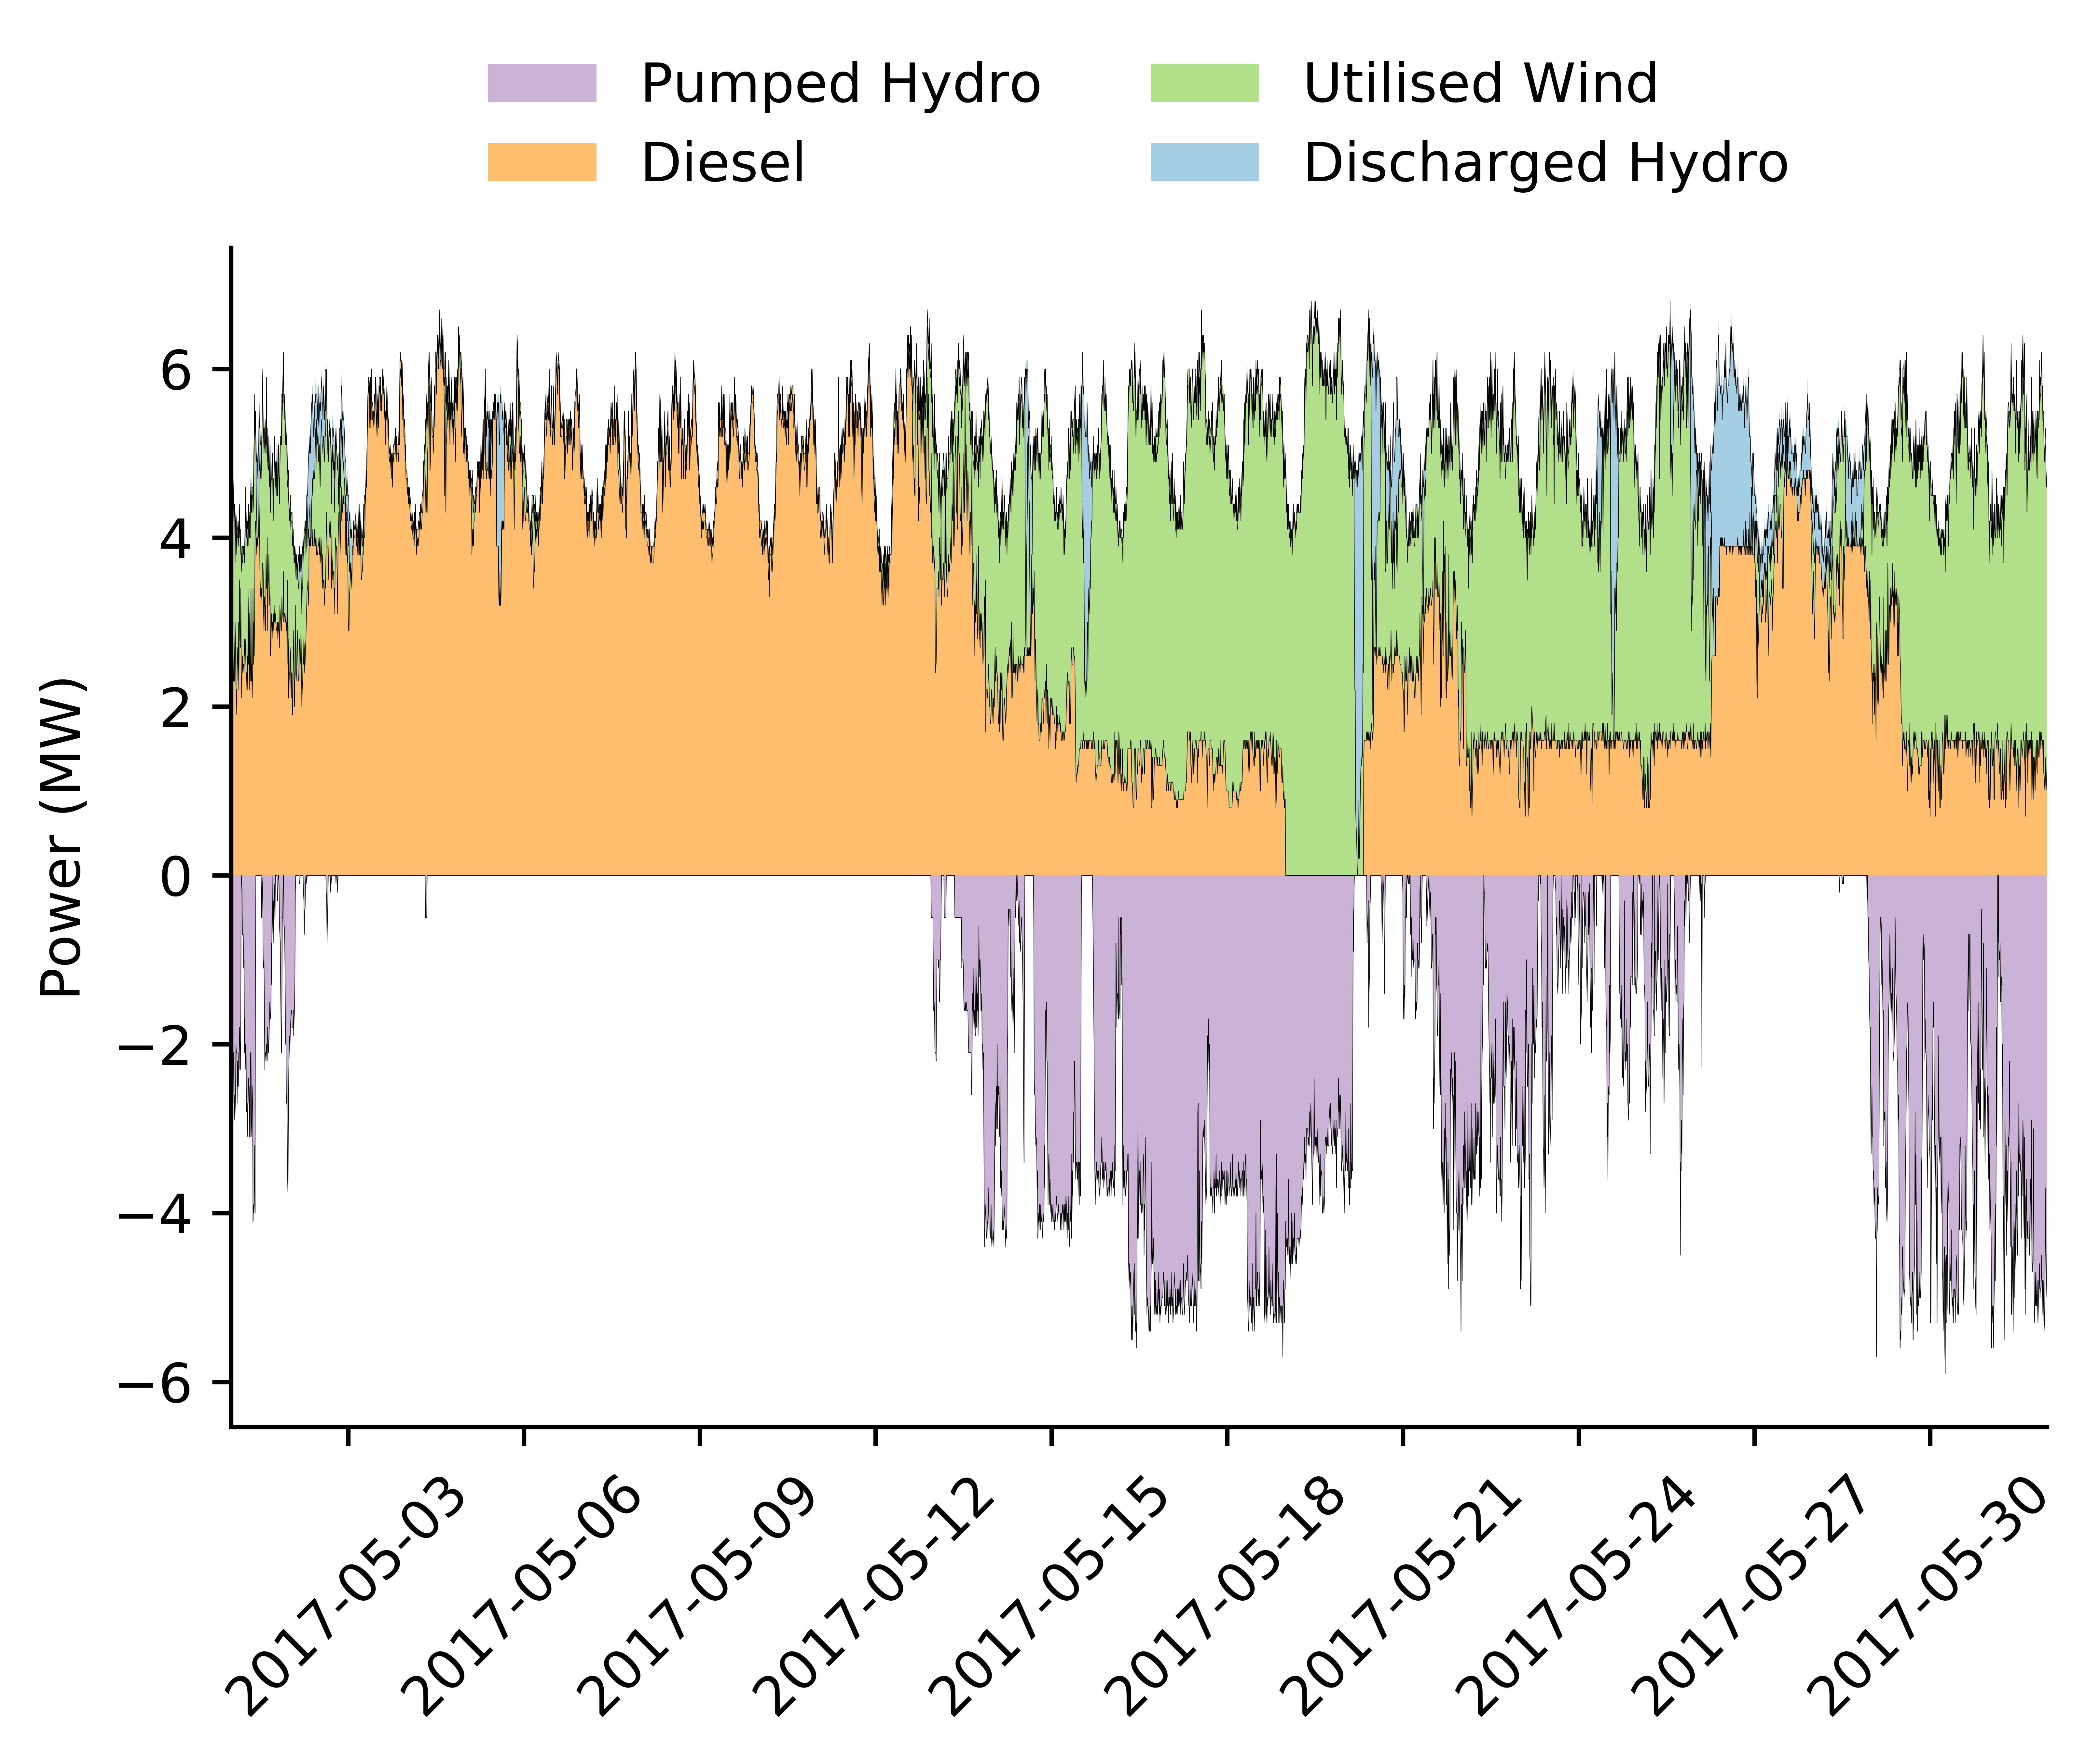

In [11]:
# df_hierro['2017-03':'2017-05'][['demand', 'diesel', 'wind', 'pump_hydro', 'dsch_hydro']].plot(ax=ax)
df_plot = df_hierro['2017-05'][['diesel', 'wind', 'pump_hydro', 'dsch_hydro']].copy()
df_plot['wind'] = df_plot['wind'] + df_plot['pump_hydro']
df_plot['pump_hydro_abs'] = df_plot['pump_hydro'].abs()
col_order = ['pump_hydro', 'pump_hydro_abs', 'diesel', 'wind', 'dsch_hydro']
labels = ['Pumped Hydro', None, 'Diesel', 'Utilised Wind', 'Discharged Hydro']
df_plot = df_plot[col_order]

## Plotting
fig = plt.figure(dpi=200)
ax = plt.subplot()

ax.stackplot(df_plot.index.values, df_plot.T, labels=labels, colors=stacked_cmap)

ax.plot(df_hierro['2017-05'].index, df_hierro['2017-05'].demand.values, 'k-', linewidth=0.1, label=None)
ax.plot(df_hierro['2017-05'].index, df_hierro['2017-05'].pump_hydro.values, 'k-', linewidth=0.1, label=None)
ax.plot(df_hierro['2017-05'].index, df_hierro['2017-05'].diesel.values, 'k-', linewidth=0.1, label=None)
ax.plot(df_hierro['2017-05'].index, df_hierro['2017-05'].wind+df_hierro['2017-05'].diesel+df_hierro['2017-05'].pump_hydro, 'k-', linewidth=0.1, label=None)

#ax.legend(bbox_to_anchor=(1, 1), frameon=False)
ax.legend(frameon=False, ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.2))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim(df_hierro['2017-05'].index.min(), df_hierro['2017-05'].index.max())
ax.set_ylabel('Power (MW)')

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
 
save_fig = False
if save_fig == True:
    plt.savefig('img/example_week.png', bbox_inches='tight')

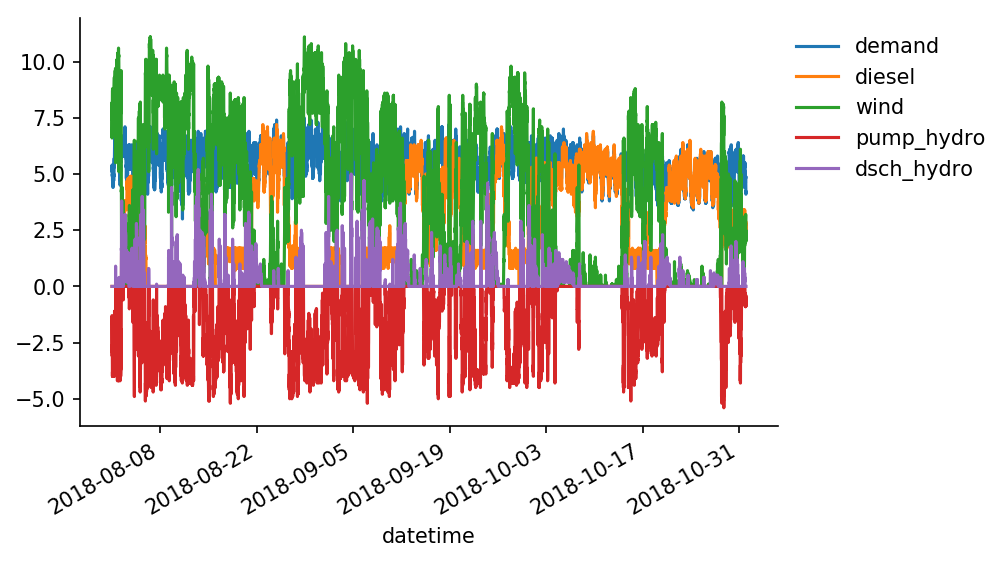

In [22]:
fig = plt.figure(dpi=150)
ax = plt.subplot()

df_hierro['2018-08':'2018-10'][['demand', 'diesel', 'wind', 'pump_hydro', 'dsch_hydro']].plot(ax=ax)

plt.legend(bbox_to_anchor=(1, 1), frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)